In [114]:
import os
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from dotenv import load_dotenv
import urllib.parse
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv()
POSTGRES_USERNAME = os.environ.get('JDB_USER')
POSTGRES_PASSWORD = os.environ.get('JDB_PASSWORD')
POSTGRES_ADDRESS = os.environ.get('JDB_HOST')
POSTGRES_PORT = 5432
POSTGRES_DBNAME = os.environ.get('JDB_NAME')
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
cnx = create_engine(postgres_str)


In [116]:
stays = pd.read_sql_query('SELECT * FROM jaildata.stays_summary where not_primary_custodian=0;',
                          cnx)
stays

,defendant_id,name,gender,race,start_date,end_date,days,min_level,max_level,has_violation,violent,dwi,flag,not_primary_custodian
0,9609,"BROOKS, JOSHUA MICHEAL",M,W,2022-01-07,2022-01-07,1.0,4,4,0,1,0,0,0
1,9615,"BUCHANAN, JONATHAN PHILLIP",M,W,2022-01-07,2022-01-07,1.0,3,3,0,0,0,0,0
2,9689,"ELLIOTT, ASHLEY NICOLE",F,W,2022-01-07,2022-01-07,1.0,2,2,0,0,0,0,0
3,9763,"HUTCHISON, MICHAEL HANNA",M,W,2022-01-07,2022-01-07,1.0,4,4,0,0,0,0,0
4,9990,"WIMBLEY, JAMES COLEY",M,B,2022-01-07,2022-01-07,1.0,1,3,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,43777,"BRANAM, KEVIN RAY",M,W,2022-03-25,2022-03-25,1.0,1,3,0,0,0,0,0
856,43799,"CANTRELL, MARGIE MARIE",F,W,2022-03-25,2022-03-25,1.0,3,3,0,0,0,0,0
857,43940,"KOLB, JAYSEN DANIEL",M,W,2022-03-25,2022-03-25,1.0,3,3,0,0,0,0,0
858,44165,"BIGWITCH, JACOB NATHANIEL",M,I,2022-03-26,2022-03-26,1.0,5,6,0,0,0,0,0


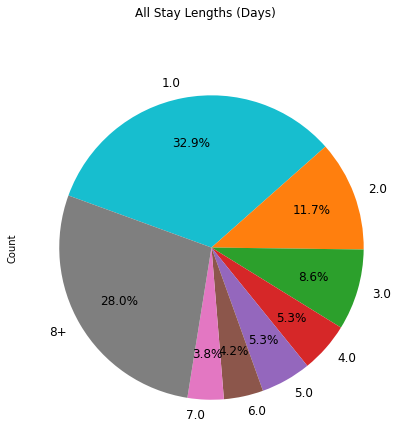

In [176]:
tmp = stays.groupby("days")["days"].count().sort_index()
days = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])
days.columns=['Count']
colors=['tab:cyan', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:blue', ]
fig = days.plot.pie(subplots=True, title="All Stay Lengths (Days)", counterclock=False, 
                  legend=False, autopct='%1.1f%%', pctdistance=.7, figsize=[7,7],
                  startangle=160, colors=colors, fontsize=12)

In [239]:
tmp = stays.loc[stays["race"] == "B"].groupby("days")["days"].count().sort_index()
daysB = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])
tmp = stays.loc[stays["race"] == "W"].groupby("days")["days"].count().sort_index()
daysW = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])

daysRace = pd.concat([daysW, daysB], axis=1)
daysRace.columns = ['White', 'Black']
daysRace.index.name = 'Days'
daysRace['Black'] = 100 * daysRace['Black']/daysRace['Black'].sum()
daysRace['White'] = 100 * daysRace['White']/daysRace['White'].sum()
daysRace

,White,Black
Days,,
1.0,33.951498,28.275862
2.0,10.984308,13.793103
3.0,8.844508,8.275862
4.0,5.278174,6.206897
5.0,5.848787,3.448276
6.0,4.422254,2.068966
7.0,3.851641,3.448276
8+,26.818830,34.482759


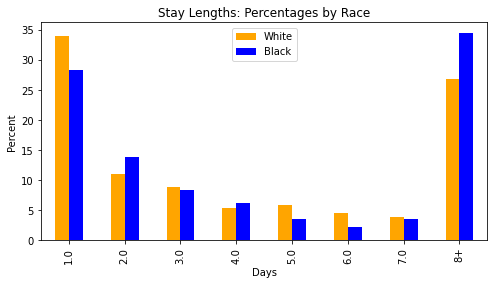

In [250]:
daysRace.plot.bar(title="Stay Lengths: Percentages by Race", figsize=[8,4], color=['Orange','Blue'])
plt.ylabel('Percent')
plt.legend()
plt.legend(bbox_to_anchor=[0.5, 0.9], loc='center', ncol=2)

plt.show()

In [243]:
tmp = stays.loc[stays["gender"] == "M"].groupby("days")["days"].count().sort_index()
daysM = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])
tmp = stays.loc[stays["gender"] == "F"].groupby("days")["days"].count().sort_index()
daysF = pd.concat([tmp.iloc[:7].copy(), pd.DataFrame([[tmp.iloc[7:].sum()]], index=['8+'])])

daysGender = pd.concat([daysM, daysF], axis=1)
daysGender.columns = ['Male', 'Female']
daysGender.index.name = 'Days'
daysGender['Male'] = 100 * daysGender['Male']/daysGender['Male'].sum()
daysGender['Female'] = 100 * daysGender['Female']/daysGender['Female'].sum()

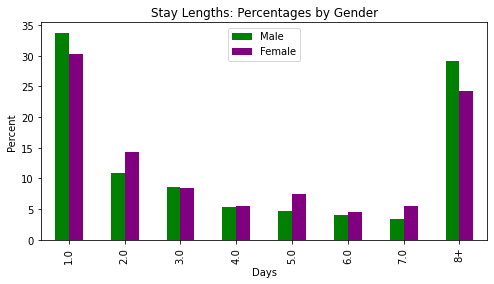

In [251]:
daysGender.plot.bar(title="Stay Lengths: Percentages by Gender", figsize=[8,4], color=['Green','Purple'])
plt.ylabel('Percent')
plt.legend(bbox_to_anchor=[0.5, 0.9], loc='center')
plt.show()

<AxesSubplot:title={'center':'Charge Level Distribution (Nonviolent) for Stays of a Week or Less'}>

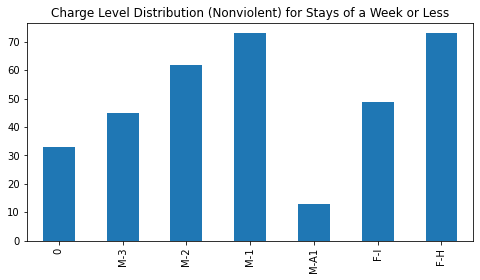

In [254]:
weekStays = stays[(stays["max_level"]<7) & (stays["days"] < 8) & (stays["violent"]==0) & (stays["has_violation"]==0)]
weekStays = weekStays.sort_values(by=["max_level"], ascending=True)
weekStays = weekStays.groupby("max_level", as_index=True)["max_level"].count().sort_index()
weekStays.index.name = 'Level'
weekStays.columns = ['Count']
weekStays.index = ['0', 'M-3', 'M-2', 'M-1', 'M-A1', 'F-I', 'F-H']

days3Stays = stays[(stays["max_level"]<7) & (stays["days"] < 4) & (stays["violent"]==0) & (stays["has_violation"]==0)]
days3Stays = days3Stays.sort_values(by=["max_level"], ascending=True)
days3Stays = days3Stays.groupby("max_level", as_index=True)["max_level"].count().sort_index()
days3Stays.index.name = 'Level'
days3Stays.columns = ['Count']
days3Stays.index = ['0', 'M-3', 'M-2', 'M-1', 'M-A1', 'F-I', 'F-H']

weekStays.plot.bar(title='Charge Level Distribution (Nonviolent) for Stays of a Week or Less', figsize=[8,4])

<AxesSubplot:title={'center':'Charge Level Distribution (Nonviolent) for Stays of 3 Days or Less'}>

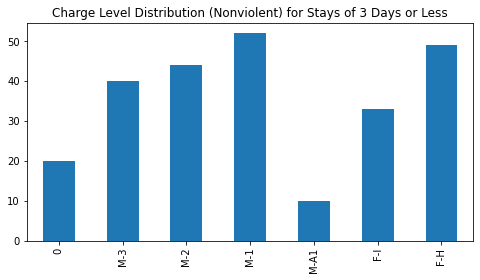

In [253]:
days3Stays.plot.bar(title='Charge Level Distribution (Nonviolent) for Stays of 3 Days or Less', figsize=[8,4])

# Map of levels:

Level|Misdemeanor Description| |Level|Felony Description| |Level |Misc Description|
:-----|:-----------| |:-----|:-----------| |:---------|:-----------|
1|Class 3| |5|Class I| |-1|NONE|
2|Class 2| |6|Class H| |-2|5305|
3|Class 1| |7|Class G| |-3|??|
4|Class A1| |8|Class F| | |
|| |9|Class E| | | |
|| |10|Class D| | | |
|| |11|Class C| | | |
|| |12|Class B1| | | |
|| |13|Class B2| | | |
|| |14|Class A| | | |
